In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("MovieLensRecommender").getOrCreate()

# Define schema for the data
ratings_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", StringType(), True)
])

movies_schema = StructType([
    StructField("movie_id", IntegerType(), True),
    StructField("movie_title", StringType(), True)
])

genre_schema = StructType([
    StructField("genre", StringType(), True),
    StructField("genre_id", IntegerType(), True)
])

user_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("age", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("zip_code", StringType(), True)
])


# Load ratings data
ratings = spark.read.csv("/FileStore/tables/movielens/u.data", schema=ratings_schema, sep="\t")
movies = spark.read.csv("/FileStore/tables/movielens/u.item", schema=movies_schema, sep="|").select("movie_id", "movie_title")
genres = spark.read.csv("/FileStore/tables/movielens/u.genre", schema=genre_schema, sep="|")
users = spark.read.csv("/FileStore/tables/movielens/u.user", schema=user_schema, sep="|")
info = spark.read.text("/FileStore/tables/movielens/u.info")



ratings.show()
movies.show()
genres.show()
users.show()
info.show(truncate=False)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
|    298|     474|     4|884182806|
|    115|     265|     2|881171488|
|    253|     465|     5|891628467|
|    305|     451|     3|886324817|
|      6|      86|     3|883603013|
|     62|     257|     2|879372434|
|    286|    1014|     5|879781125|
|    200|     222|     5|876042340|
|    210|      40|     3|891035994|
|    224|      29|     3|888104457|
|    303|     785|     3|879485318|
|    122|     387|     5|879270459|
|    194|     274|     2|879539794|
|    291|    1042|     4|874834944|
|    234|    1184|     2|892079237|
+-------+--------+------+---------+
only showing top 20 rows

+--------+--------------------+
|movie_id|         movie_title|
+--------+--------------------+
|       1|    

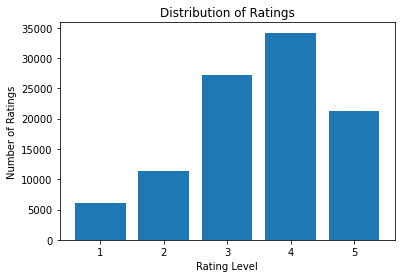

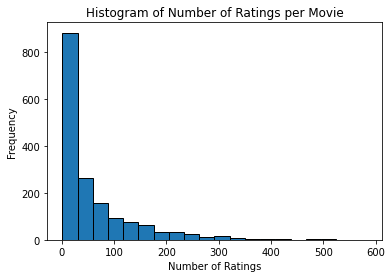

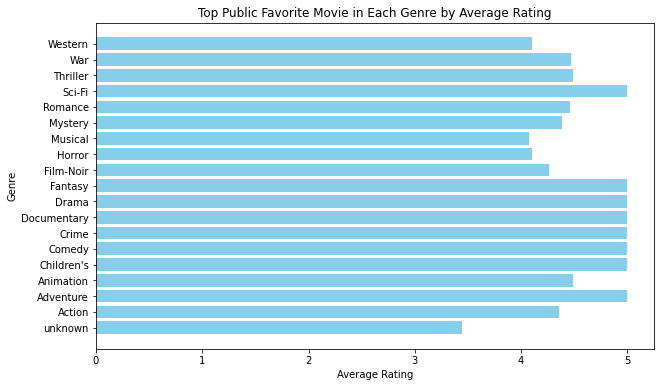

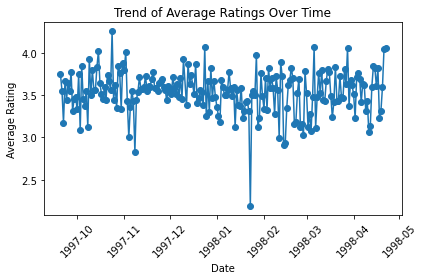

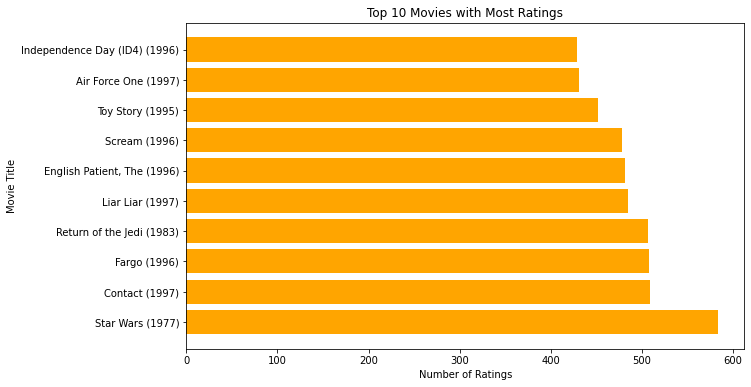

In [0]:
from pyspark.sql.functions import avg, count, col, desc, from_unixtime
import matplotlib.pyplot as plt
import pandas as pd



# 1. Number of Ratings for Each Rating Level
rating_counts = ratings.groupBy("rating").count().orderBy("rating").toPandas()

# Plotting the distribution of ratings
plt.bar(rating_counts["rating"], rating_counts["count"])
plt.xlabel("Rating Level")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.show()

# 2. Histogram of Number of Ratings per Movie
ratings_per_movie = ratings.groupBy("movie_id").count().withColumnRenamed("count", "num_ratings")
ratings_hist = ratings_per_movie.select("num_ratings").toPandas()

# Plotting histogram
plt.hist(ratings_hist["num_ratings"], bins=20, edgecolor='black')
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Ratings per Movie")
plt.show()

# 3. Public Favorite Movies in Each Genre
# Add genre flags to the ratings dataset
movies_with_genres = movies.join(movies_with_genres, "movie_id")  # Join with genre flags

# Get the average rating for each genre
genre_ratings = {}
for genre in genres.select("genre").rdd.flatMap(lambda x: x).collect():
    avg_ratings_genre = ratings.join(movies_with_genres, "movie_id").filter(col(genre) == 1) \
        .groupBy("movie_id").agg(avg("rating").alias("avg_rating")) \
        .orderBy("avg_rating", ascending=False).limit(1) \
        .join(movies, "movie_id").select("movie_title", "avg_rating").collect()
    genre_ratings[genre] = avg_ratings_genre[0]

# Convert to DataFrame for plotting
genre_ratings_df = pd.DataFrame({
    "Genre": [k for k in genre_ratings.keys()],
    "Top Movie": [v["movie_title"] for v in genre_ratings.values()],
    "Average Rating": [v["avg_rating"] for v in genre_ratings.values()]
})

# Plotting top-rated movies by genre
plt.figure(figsize=(10, 6))
plt.barh(genre_ratings_df["Genre"], genre_ratings_df["Average Rating"], color='skyblue')
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title("Top Public Favorite Movie in Each Genre by Average Rating")
plt.show()

# 4. Ratings Over Time (Optional if Timestamp Data is Preprocessed)
ratings_with_date = ratings.withColumn("date", from_unixtime(col("timestamp").cast("long")).cast("date"))
ratings_trend = ratings_with_date.groupBy("date").agg(avg("rating").alias("avg_rating")).orderBy("date").toPandas()

# Plotting trend of average ratings over time
plt.plot(ratings_trend["date"], ratings_trend["avg_rating"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.title("Trend of Average Ratings Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Top Movies with Most Ratings
top_movies_by_ratings = ratings_per_movie.join(movies, "movie_id").orderBy(desc("num_ratings")).limit(10).toPandas()

# Plotting the movies with the most ratings
plt.figure(figsize=(10, 6))
plt.barh(top_movies_by_ratings["movie_title"], top_movies_by_ratings["num_ratings"], color='orange')
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Movies with Most Ratings")
plt.show()


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Train-test split
(training, test) = ratings.randomSplit([0.8, 0.2])

# Define ALS model
als = ALS(
    userCol="user_id",
    itemCol="movie_id",
    ratingCol="rating",
    nonnegative=True,
    coldStartStrategy="drop"
)

# Train the model
model = als.fit(training)

# Evaluate the model
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print(f"Root-mean-square error: {rmse}")


Root-mean-square error: 0.9246352241021268


In [0]:
# 1. The top recommendation for each user
user_recommendations = model.recommendForAllUsers(1)

# 2. Explode recommendations for better readability
from pyspark.sql.functions import explode

recommendations = user_recommendations.select("user_id", explode("recommendations").alias("recommendation"))
recommendations = recommendations.select("user_id", "recommendation.movie_id", "recommendation.rating")

# 3. Add movie titles to recommendations
recommendations_with_titles = recommendations.join(movies, "movie_id")

# Show recommendations for the first user
recommendations_with_titles.filter(col("user_id") == 1).show()


+--------+-------+---------+--------------------+
|movie_id|user_id|   rating|         movie_title|
+--------+-------+---------+--------------------+
|    1449|      1|5.1955085|Pather Panchali (...|
+--------+-------+---------+--------------------+



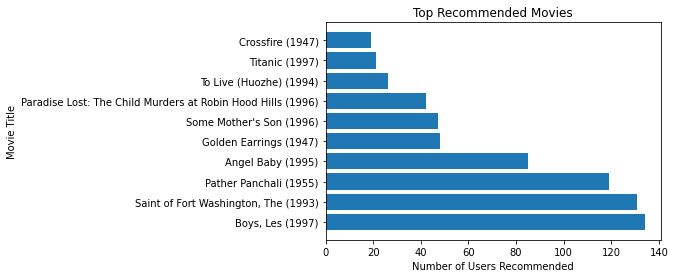

In [0]:
# Save recommendations
recommendations_with_titles.write.csv("/FileStore/recommendations_1user.csv", header=True)

# Visualize top recommended movies
top_recommended_movies = recommendations_with_titles.groupBy("movie_id").agg(count("user_id").alias("user_count"))
top_recommended_movies = top_recommended_movies.join(movies, "movie_id").orderBy("user_count", ascending=False).limit(10)

# Plot
top_movies_df = top_recommended_movies.toPandas()
plt.barh(top_movies_df["movie_title"], top_movies_df["user_count"])
plt.xlabel("Number of Users Recommended")
plt.ylabel("Movie Title")
plt.title("Top Recommended Movies")
plt.show()


In [0]:
recommendations_with_titles.display()

movie_id,user_id,rating,movie_title
1449,1,5.1955085,Pather Panchali (1955)
1449,2,4.773265,Pather Panchali (1955)
1463,3,4.27937,"Boys, Les (1997)"
1368,4,5.968327,Mina Tannenbaum (1994)
1589,5,4.723507,Schizopolis (1996)
1463,6,5.043045,"Boys, Les (1997)"
1449,7,5.2160077,Pather Panchali (1955)
1467,8,4.9738374,"Saint of Fort Washington, The (1993)"
1642,9,5.4375424,Some Mother's Son (1996)
1449,10,5.188936,Pather Panchali (1955)
